# Warehouse allocation + Capacitated VRP

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from random import randint
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("aachen_address_with_distance.csv")
df

,Unnamed: 0,id,street,house_no,geom,longitude,latitude,zip_code,x,y,...,distance_km_from_1,distance_km_from_2,distance_km_from_3,distance_km_from_4,distance_km_from_5,distance_km_from_6,distance_km_from_7,distance_km_from_8,distance_km_from_9,demand_kg
0,0,3200.0,Aachener Straße,11,298136.611 5624134.902,6.139304,50.733879,52076,5.647670e+06,684735.702468,...,5.494804,5.524951,4.851436,6.449841,5.451486,2.080050,8.892471,7.098870,4.579297,0
1,1,2230.0,Aachener-und-Münchener-Allee,1,293683.424 5627354.953,6.074479,50.761234,52074,5.650715e+06,677478.268930,...,0.000000,1.403179,1.090631,2.451331,2.169467,5.079873,4.252867,5.501129,3.063949,6494
2,2,3632.0,AachenMünchener-Platz,1,294621.785 5628398.439,6.087184,50.770939,52064,5.651795e+06,678900.586131,...,1.403179,0.000000,0.803129,1.192714,0.791092,4.583389,3.458832,4.101437,1.930534,15202
3,3,3663.0,Abteiblick,2,294745.197 5627604.753,6.089375,50.763854,52066,5.651006e+06,679145.826984,...,1.090631,0.803129,0.000000,1.984889,1.315692,4.136427,4.242948,4.604346,1.987134,14797
4,4,1004.0,Achterstraße,2,294692.725 5629589.182,6.087524,50.781658,52062,5.652988e+06,678938.654597,...,2.451331,1.192714,1.984889,0.000000,1.003677,5.215092,2.444782,3.334121,2.189991,19132
5,5,2000.0,Adalbertsteinweg,1,295306.477 5628794.884,6.096661,50.774741,52070,5.652218e+06,679961.535810,...,2.169467,0.791092,1.315692,1.003677,0.000000,4.234892,3.447725,3.336472,1.297433,10585
6,6,1005.0,Adalbert-Stifter-Straße,1,298620.846 5626158.014,6.145051,50.752218,52078,5.649711e+06,685379.213666,...,5.079873,4.583389,4.136427,5.215092,4.234892,0.000000,7.611875,5.157151,3.073707,9336
7,7,2901.0,Adele-Weidtman-Straße,1,293287.105 5631589.842,6.066487,50.799127,52072,5.654933e+06,676583.527989,...,4.252867,3.458832,4.242948,2.444782,3.447725,7.611875,0.000000,4.332963,4.541915,16540
8,8,2801.0,Ahornweg,2,297604.276 5631214.509,6.127876,50.797280,52080,5.654727e+06,683456.285653,...,5.501129,4.101437,4.604346,3.334121,3.336472,5.157151,4.332963,0.000000,2.974533,18127
9,9,1019.0,Alsenstraße,1,296552.248 5628431.893,6.114507,50.771919,52068,5.651904e+06,681959.541325,...,3.063949,1.930534,1.987134,2.189991,1.297433,3.073707,4.541915,2.974533,0.000000,954


In [3]:
process_df = df.copy()

### 1. Assign depot and customers

In [4]:
x_all = process_df['longitude']
y_all = process_df['latitude']

depot_condition = process_df['zip_code'] == 52076
depot = process_df[depot_condition]
customers = process_df[~depot_condition]

x_depot = depot['longitude']
y_depot = depot['latitude']

x_cus = customers['longitude'] # x-axis, can be replaced with customers' location
y_cus = customers['latitude'] # y-axis, can be replaced with customers' location
zip_code = customers['zip_code']

### Visualization

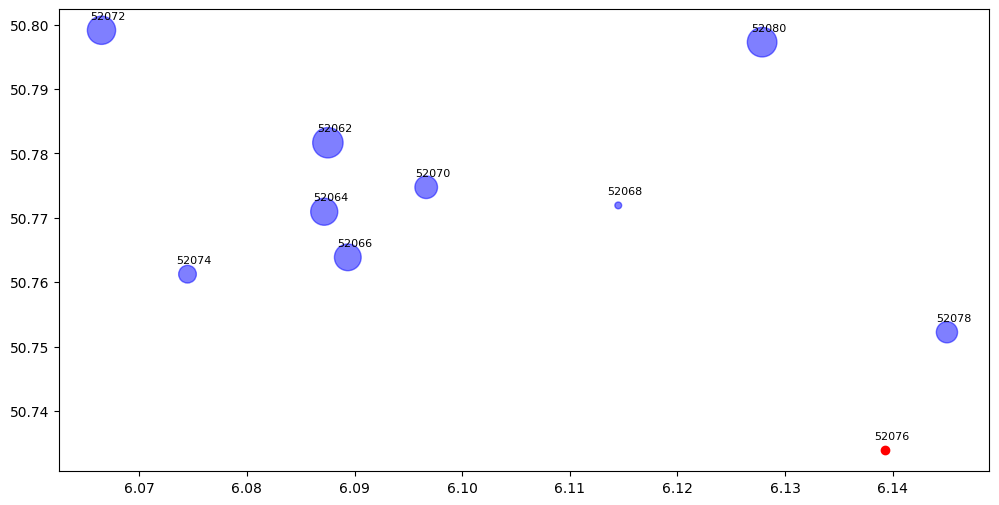

In [5]:
d_list = [d/40 for d in process_df["demand_kg"]]
d_list.remove(0)

plt.figure(figsize=(12,6))
plt.plot(x_depot, y_depot, c='r', marker='o') # Depot
plt.scatter(x_cus, y_cus, c='b', marker="o", s = d_list, alpha=0.5) # Client
for idx, row in process_df.iterrows():
    plt.annotate(row['zip_code'], (row['longitude'], row['latitude']), textcoords='offset points', xytext=(-8,8), family='sans-serif', fontsize=8)

### Decise the number of clusers - tuning k

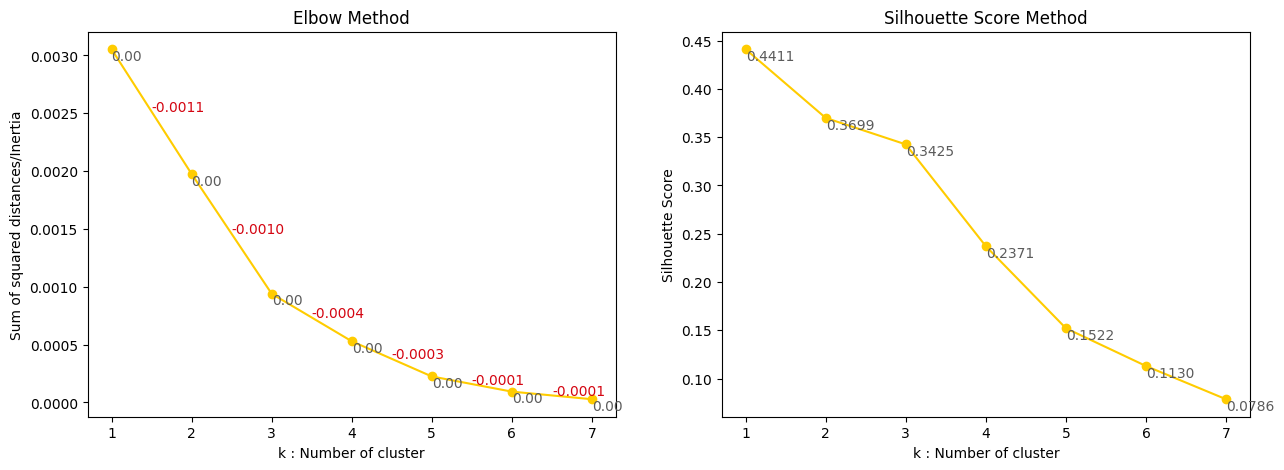

In [6]:
from sklearn.metrics import silhouette_score
data = pd.DataFrame()
data["xc"] = x_cus
data["yc"] = y_cus

max_k = 8
n_init = 9 # Initial centroids will be chosen {n_int} times
max_iter = 1000 # each run will run {max_iter} times

# Elbow Method:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
x = range(1, max_k)
y_sse = []
for k in range(2, max_k+1):
    kmeans = KMeans(n_init=n_init, max_iter=max_iter, n_clusters=k, random_state=42)
    kmeans.fit(data)
    y_sse.append(kmeans.inertia_)

# Add annotations or markers for the differences
differences = [y_sse[i] - y_sse[i-1] for i in range(1, len(y_sse))]
for i, diff in enumerate(differences):
    ax[0].annotate(f"{diff:.4f}", ((x[i]+x[i+1])/2, (y_sse[i]+y_sse[i+1])/2), color='#d40511')

# Plot the data point
for i, j in zip(x, y_sse):
    ax[0].text(i, j, f"{j*10**(-9):.2f}", ma='center', va='top', color='#5b5b5b')

ax[0].plot(x, y_sse, 'o-', color='#ffcc00')
ax[0].set_xlabel('k : Number of cluster') 
ax[0].set_ylabel('Sum of squared distances/Inertia') 
ax[0].set_title('Elbow Method')

# Silhouette Score Method
y_silhouette = []
for k in range(2, max_k+1):
    kmeans = KMeans(n_init=n_init, max_iter=max_iter, n_clusters=k, random_state=42).fit(data)
    y_silhouette.append(silhouette_score(data, kmeans.labels_))

# Plot the data point
for i, j in zip(x, y_silhouette):
    ax[1].text(i, j, f"{j:.4f}", ma='center', va='top', color='#5b5b5b')

ax[1].plot(x, y_silhouette,'o-', c='#ffcc00')
ax[1].set_title("Silhouette Score Method")
ax[1].set_xlabel("k : Number of cluster")
ax[1].set_ylabel("Silhouette Score")
plt.show()

### => From the results of Elbow method and Silhouette, decide to select cluster num k = 3

## Need to check which districting results in the minimum cost

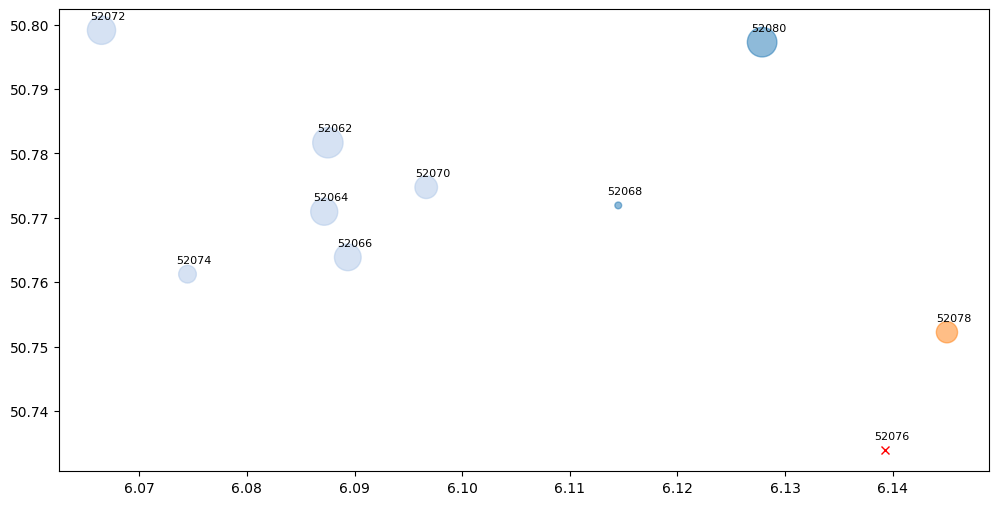

In [7]:
cmap = plt.get_cmap('tab20')
color_map_hex = [mpl.colors.to_hex(c) for c in cmap.colors]

cluster_number = 3
plt.figure(figsize=(12,6))
plt.plot(x_depot, y_depot, color='red', marker='x', linestyle='None', label='Depot') # Depot

# Fit K-mean cluster
cluster_kmeans = KMeans(n_clusters=cluster_number, n_init=n_init).fit(data)

plt.scatter(x_cus, y_cus, c=[color_map_hex[x] for x in cluster_kmeans.labels_], marker="o", s = d_list, alpha=0.5)
for idx, row in process_df.iterrows():
    plt.annotate(row['zip_code'], (row['longitude'], row['latitude']), textcoords='offset points', xytext=(-8,8), family='sans-serif', fontsize=8)
plt.show()

In [8]:
# Write the result to csv
import csv
    
def write_sol_warehouse(mdl):
    rows = []
    for v in mdl.getVars():
        if v.X != 0:
            rows.append([v.VarName,v.X])
    header = ['VarName', 'value']
    with open(f'solution_warehouse.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Objective Value", mdl.ObjVal])
        writer.writerow(header)
        writer.writerows(rows)

# Warehouse Allocation
### Objective: Evenly allocate demand among gates at the warehouse by minimizing the deviation of demands at each gate from the ideal demand of each gate.

### Minimize:  
### $\displaystyle\sum_{j=1}^{m} \left| dg_j - \sum_{i=1}^{n} dt_i/3 \right|$<br>

### s.t.
### - Demand relaxation. The demand at gates is relaxed by 10 percent.
### $(0.9 * \displaystyle\sum_{i} dt_i * t_{i,j}) / 3 \le dg_j \le (1.1 * \sum_{i} dt_i * t_{i,j}) / 3, \forall j \in \{1, ..., m\}$<br><br>
### - Tour area assignment. Each tour area is assigned only one gate.
### $\displaystyle\sum_{j} t_{i,j} = 1, \forall i \in \{1, ..., n\}$<br><br>
### - Tour areas at gates. # Each gate is assigned at least one tour area.
### $\displaystyle\sum_{i} t_{i,j} \ge 1, \forall j \in \{1, ..., m\}$<br><br>
### - Demand at tour areas and gates. Sum of demands of selected tour areas at a gate should be equal to the relaxed demand at that gate.
### $\displaystyle\sum_{i} t_{i,j} * dt_i = dg_j, \forall j \in \{1, ..., m\}$<br><br>
### - Total demand. Sum of demands of all tour areas is equal to the sum of demands at all gates.
### $\displaystyle\sum_{i} t_{i,j} = \sum_{j} dg_j$<br><br><br>
### Constraints
### $dg_j \in Q_+, \forall j \in \{1, ..., m\}$ <br>
### $dt_i \in Q_+, \forall i \in \{1, ..., n\}$

# Gurobi
Documentation: https://www.gurobi.com/documentation/

In [9]:
import gurobipy as gp
from gurobipy import GRB, quicksum

In [10]:
mdl_allocation = gp.Model("Warehouse Allocation")
mdl_allocation.reset(0)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-12
Discarded solution information


### Set up variables

In [11]:
demands = process_df["demand_kg"] # Include depot

customer_demands = demands[1:].tolist() # Customer demand
clustered_result = cluster_kmeans.labels_.tolist()

dist_zip_map = {k: [] for k in range(cluster_number+1)} # Disctrict - zipcode map
zip_dist_map = {0:0} # Zipcode - disctrict map

for idx, dist in enumerate(clustered_result):
    zip_dist_map[idx+1] = dist+1
for idx, district in enumerate(clustered_result):
    dist_zip_map[district+1].append(idx+1) # District starts from 1

print(f"dist_zip_map: {dist_zip_map}\nzip_dist_map: {zip_dist_map}")

dist_zip_map: {0: [], 1: [8, 9], 2: [1, 2, 3, 4, 5, 7], 3: [6]}
zip_dist_map: {0: 0, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 3, 7: 2, 8: 1, 9: 1}


In [12]:
# All start from index 1
gates = [i for i in range (1, 4)] # Change gate number here
clusters = [i for i in range (1, cluster_number+1)]
ideal_value = sum(customer_demands) / len(gates)

In [13]:
dt = {}
for t in range(1, len(clusters)+1):
    dt[t] = sum(demands[j] for j in dist_zip_map[t])
dt

{1: 19081, 2: 82750, 3: 9336}

In [14]:
mdl_allocation = gp.Model("Warehouse Allocation")

# Objective function
abs_var = mdl_allocation.addVars(gates, lb=0) 
mdl_allocation.modelSense = GRB.MINIMIZE
mdl_allocation.setObjective(gp.quicksum(abs_var[j] for j in gates))

# Decision variables
dg = mdl_allocation.addVars(gates, lb=0, vtype=GRB.CONTINUOUS, name="dg") # Demand of gate j
t = mdl_allocation.addVars(clusters, gates, vtype=GRB.BINARY, name="t") # Whether tour area i is allocated to gate j or not

In [15]:
# Change objective function to linear.
mdl_allocation.addConstrs(((abs_var[j] >= dg[j] - ideal_value) for j in gates), name="obj-to-linear-1")
mdl_allocation.addConstrs(((abs_var[j] >= -dg[j] + ideal_value) for j in gates), name="obj-to-linear-2")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>}

In [16]:
# Demand relaxation. By +- 10 percent at gates.
for j in gates:
    mdl_allocation.addConstr((quicksum(0.9 * dt[i] * t[i,j] for i in clusters) <= dg[j]), name=f"lhs-demand-relaxation-g{j}")
    mdl_allocation.addConstr((quicksum(1.1 * dt[i] * t[i,j]for i in clusters) >= dg[j]), name=f"rhs-demand-relaxation-g{j}")

In [17]:
# tour area assignment. Each tour area is assigned only one gate.
mdl_allocation.addConstrs((quicksum(t[i,j] for j in gates) == 1 for i in clusters), name=f"tour-area-assignment-t{i}")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>}

In [18]:
# Tour areas at gates. Each gate is assigned at least one tour area.
mdl_allocation.addConstrs((quicksum(t[i,j] for i in clusters) >= 1 for j in gates), name=f"each-gate-at-least-one-tour-area")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>}

In [19]:
# Demand at tour areas and gates. Sum of demands of selected tour areas at a particular gate should be equal to the relaxed demand of that gate.
mdl_allocation.addConstrs((quicksum(t[i,j] * dt[i] for i in clusters) == dg[j] for j in gates), name=f"demand-tour-gate-relation")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>}

In [20]:
# Sum of demands of all tour areas is equal to the sum of demands of all gates.
mdl_allocation.addConstr(quicksum(dg[j] for j in gates) == sum(dt[i]for i in clusters), name=f"all-demand-assigned")

<gurobi.Constr *Awaiting Model Update*>

In [21]:
need_print_mdl = False # For debugging
if need_print_mdl:
    mdl_allocation.write("model_allocation.lp")

mdl_allocation.optimize()
if mdl_allocation.Status == GRB.INFEASIBLE:
    mdl_allocation.computeIIS()
    mdl_allocation.write("result_warehouse_iis.ilp")
# Print the solution
elif mdl_allocation.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    # print(mdl.PoolObjVal) # Objective value of alternatives solutions stored during the optimization process
    write_sol_warehouse(mdl_allocation)
elif mdl_allocation.Status == GRB.TIME_LIMIT:
    print("Reached time limit!")
    write_sol_warehouse(mdl_allocation)
else:
    print("No solution found.")

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 22 rows, 15 columns and 69 nonzeros
Model fingerprint: 0xce5fcdd3
Variable types: 6 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 6 rows and 0 columns
Presolve time: 0.00s
Presolved: 16 rows, 15 columns, 54 nonzeros
Variable types: 0 continuous, 15 integer (9 binary)
Found heuristic solution: objective 91388.666667

Root relaxation: cutoff, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      91388.6667 91388.6667  0.00%     -    0s

Explored 1 nodes (9 simplex ite

# CVRP
### Objective: Minimize the total transportation cost.

### Minimize:  
### $\displaystyle\sum_{k \in T} \sum_{(i, j) \in A} x^k_{(i,j)} c_{(i,j)} + \sum_{k \in T, j \in N} x^k_{(0,j)} F_k $<br>

### s.t.
### - Can only travel within tour areas. Make invalid arcs zero
### $x^{k}_{(i, j)} = 0, \forall (i,j) \notin A, k \in T$<br><br>
### - Truck usage. Each truck can only be used at most once.
### $\displaystyle\sum_{j \in N} x^k_{(0,j)} \le 1, k \in T$<br><br>
### - In-coming and out-going limitation. The number of vehicles coming in and out of a customer’s location is the same.
### $\displaystyle\sum_{i \in V, i \neq j} x^k_{(i, j)} - \sum_{i \in V} x^k_{(j, i)} = 0, \forall j \in V, k \in T$
### - Zip code visit. Only one visit per vehicle per customer’s location.
### $\displaystyle\sum_{k \in T} \sum_{i \in V, i \neq j} x^k_{(i, j)} = 1, \forall j \in V  \backslash \{0\}$
### - Capacity constraint. 
### 1. $u_i^k + q_j <= u_i^k + M * (1-x_{(i,j)}^k) \quad \forall k\in T, (i,j)\in A:j\neq 0,i\neq 0,i\neq j$ # If truck k visits zip code i ($u^k_{i}$), then the total load after visiting zip code i plus the demand at zip code j ($q_{j}$) must not exceed the total load after visiting zip code j ($u^k_{j}$), unless the arc (i, j) is not selected ($x^k_{(i,j)} = 0$). This constraint ensures that the vehicle’s capacity limitations are respected during the routing process.<br>
<!-- if truck k visited i, the loading after visiting i + demand in j cannot exceed trucking loading after visiting j<br><br> -->
### 2. $\displaystyle\sum_{i, j \in A}q_i * x_{(j,i)}^k \leq Q_k \quad ,\forall k\in T$ # Total demand of zip codes served by truck k cannot exceed truck k’s capacity.
<br>
<!-- total demand of zip codes served by truck k cannot exceed truck k’s capacity -->

#### 1.1 Set Description
$N = \{1,2,\ldots,n\}$: the set of $n$ zip codes<br>
$V = \{d,1,2,\ldots,n\}$: the set of $n$ zip codes includes the depot $d$<br>
$T = \{1,2,\ldots,t\}$: the set of $k$ trucks<br>
$A$: the set of valid arcs<br>
$M = \{1, 2, 3, 4, 5\}$: the set of truck types<br>
(1: type-4, 2: type-5, 3: type6-, 4: type-7, 5: type-9)<br>
$TM\_map$ = \{1:385.09 €, 2:350.95€, 3:385.86€, 4:405.63€, 5:430.26€\}: the truck price, which is the average price of each type of vehicle.<br>
$TQ\_map$ = \{1:800, 2:2800, 3:5500, 4:20000, 5:20000\}: the truck capacity

#### 1.2 Variable Description
$n$: the number of zip codes<br>
$k$: the number of trucks<br>
$m$: the number of truck types<br>
$q_i \in\mathbf{R} \quad ,\forall i\in N$: the zip-code $i$'s demand<br>
$c_{ij}\in\mathbf{R}\quad\forall i,j \in A$: the travel cost(distance) between zip code $i$ and $j$<br>
$Q^k \in \mathbf{Q_+} \quad \forall k\in T, p \in P$: the truck k's capacity<br>
$F^k \in \mathbf{Q_+} \quad \forall k\in T, p \in P$: the truck k's price<br>

#### 1.3 Parameter Description
$x_{ij}^k \in\{0,1\} \quad ,\forall i,j\in A, k\in T$: truck $k$ travels from zip code $i$ to $j$<br>
$u_i^k\in\mathbf{Z_+}  \quad ,\forall  i\in N, k\in T$: $k$ truck loading after visiting zip code $i$

In [22]:
mdl = gp.Model("CVRP")
mdl.reset(0)

Discarded solution information


In [23]:
# Create type_number_map

# Pick certain date
vehicle_df = pd.read_csv("vehicles.csv")
filtered_df = vehicle_df.loc[vehicle_df['Date'] == "31/3/2023"]

# Max vehicles should be used (dynamic)
max_vehicles = filtered_df["Vehicle / Day_modified"].sum()

# The set of truck types
M = [1, 2, 3, 4, 5] # "type4", "type5", "type6", "type7", "type9"

# Set map for type and available vehicle number
type_number_map = {}

# Only for Fahrzeugklasse mapping to M
real_type_map = {
    4:0,
    5:1,
    6:2,
    7:3,
    9:4
}

# Set available number of truck to each type
for i, row in filtered_df.iterrows():
    type_number_map[M[real_type_map[row["Vehicle_class"]]]] = row["Vehicle / Day_modified"]

# Handle certain type not used
for i in M:
    try:
        type_number_map[i]
    except KeyError:
        type_number_map[i] = 0
type_number_map

{1: 1, 2: 7, 3: 25, 4: 6, 5: 22}

In [24]:
# The set of zip codes that belong to the k-th cluster
N = [i for i in range (1, len(customers)+1)] # The set of zip codes
V = [i for i in range (len(process_df))] # The set of all nodes (include depot)
T = [k for k in range(1, max_vehicles+1)] # Max truck num we have

 # Valid arcs
A = []
for i in V:
    # From / to depot 
    if i == 0:
        A.extend([(i,k) for k in V if i != k])
        A.extend([(k,i) for k in V if i != k])
    A.extend([(i,j) for j in dist_zip_map[zip_dist_map[i]] if j != i])

# Type capacity map
TQ_map = {
    0: 0,
    M[0]: 800, # type 4
    M[1]: 2800, # type 5
    M[2]: 5500, # type 6
    M[3]: 20000, # type 7
    M[4]: 20000, # type 9
}

# Type price map. Use the monthly average price from the vehicle data.
TM_map = {
    0:0,
    M[0]: 385.09, # type 4
    M[1]: 350.95, # type 5
    M[2]: 385.86, # type 6
    M[3]: 405.63, # type 7
    M[4]: 430.26, # type 9
}

# Assign type to each truck
Q = {}
F = {}
truck_type_map = {}
count = 1
for i in M:
    for j in range (type_number_map[i]):
        Q[count] = TQ_map[i]
        F[count] = TM_map[i]
        truck_type_map[count] = i
        count += 1

print(f"N: {N} \nV: {V}\nT: {T}\nA: {A}\nM: {M}\nQ: {Q}\nF: {F}")

# Number of customers
num_customers = len(demands) - 1

# Distance
c = {} 
for i in range(len(process_df)):
    for j, row in process_df.iterrows():
        c[(i,j)] = row[f"distance_km_from_{i}"] # Use distances in test_data.csv

# Demand of zip code
q = {}
for idx, demand in enumerate(demands):
    q[idx] = demand

N: [1, 2, 3, 4, 5, 6, 7, 8, 9] 
V: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
T: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
A: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 7), (2, 1), (2, 3), (2, 4), (2, 5), (2, 7), (3, 1), (3, 2), (3, 4), (3, 5), (3, 7), (4, 1), (4, 2), (4, 3), (4, 5), (4, 7), (5, 1), (5, 2), (5, 3), (5, 4), (5, 7), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 9), (9, 8)]
M: [1, 2, 3, 4, 5]
Q: {1: 800, 2: 2800, 3: 2800, 4: 2800, 5: 2800, 6: 2800, 7: 2800, 8: 2800, 9: 5500, 10: 5500, 11: 5500, 12: 5500, 13: 5500, 14: 5500, 15: 5500, 16: 5500, 17: 5500, 18: 5500, 19: 5500, 20: 5500, 21: 5500, 22: 5500, 23: 5500, 24: 5500, 25: 5500, 26: 5500, 27: 5500, 28: 5500

In [25]:
big_M = 20001

mdl = gp.Model("CVRP")
x = mdl.addVars(V, V, T, vtype=GRB.BINARY, name="x") # Whether truck k travels from zip code i to j?
u = mdl.addVars(V, T, lb=0, ub=20000, vtype=GRB.CONTINUOUS, name="u") # Truck k loading after visiting zip code i, and need to be positive value

# Objective function
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(c[(i,j)] * x[i, j, k] for i,j in A for k in T) + quicksum(F[k] * x[0, j, k] for j in N for k in T))

In [26]:
# Can only travel within tour areas. If i, j not in valid arc, set 0
mdl.addConstrs((x[i, j, k] == 0 for i in V for j in V for k in T if (i,j) not in A), name=f"only-travel-tour-area")

{(0, 0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (4, 9, 24): <gurobi.Constr *Awaiting Model Update*>,
 ...}

In [27]:
# In-coming and out-going limitation. The number of vehicles coming in and out of a customer’s location is the same
for j in V:
    for k in T:
        mdl.addConstr((quicksum(x[i, j, k] for i in V if i != j) - quicksum(x[j, i, k] for i in V) == 0), name=f"in-out-{j}-{k}")

In [28]:
# Zip Code visit. Every zip-cide is exactly visited once
for j in N:
    mdl.addConstr((quicksum(x[i, j, k] for k in T for i in V if i != j) == 1), name=f"zip-vistied-once-{j}")

In [29]:
# Each truck can only be used at most once
mdl.addConstrs((quicksum(x[0, j, k] for j in N) <= 1 for k in T), name=f"truck-only-depart-once")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 60: <gurobi.Constr *Awaiting Model Update*>,
 61: <gurobi.Constr *Awaiting Model Update*>}

In [30]:
# Capacity constraint. If truck k visited i, the loading after visiting i + demand in j cannot exceed trucking loading after visiting j
mdl.addConstrs((u[i, k]+q[j] <= u[j, k] + big_M * (1-x[i,j,k]) for i, j in A for k in T if i !=0 and j != 0), name=f"loading")
for k in T:
    mdl.addConstr((quicksum(q[j] * x[i,j,k] for i, j in A) <= Q[k]), name=f"demand-of-k{k}-visited")

In [31]:
def write_sol(mdl):
    rows = []
    used = 0
    truck_total_cost = 0
    used_truck_type = {}
    for v in mdl.getVars():
        if v.X == 0:
            continue
        rows.append([v.VarName,v.X])
        # calculate how many trucks are used
        if "x[0," not in v.VarName:
            continue
        used += 1
        
        # print truck cost
        end = v.VarName.find("]", 0)
        sub = v.VarName[:end]
        k = int(sub.split(',')[-1])
        truck_total_cost += F[k]
        try:
            used_truck_type[f'{Q[k]}_{F[k]}'] += 1
        except KeyError:
            used_truck_type[f'{Q[k]}_{F[k]}'] = 1
    header = ['VarName', 'value']
    with open(f'solution_cvrp.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Objective Value", mdl.ObjVal])
        writer.writerow(["Truck Used", used])
        writer.writerow(["Total Distance", mdl.ObjVal-truck_total_cost])
        writer.writerow(["Truck Total Cost", truck_total_cost])
        writer.writerow(["Used Truck Type", used_truck_type])
        writer.writerow(header)
        writer.writerows(rows)

In [32]:
if need_print_mdl:
    mdl.write(f"model_cvrp.lp")

mdl.optimize()
if mdl.Status == GRB.INFEASIBLE:
    mdl.computeIIS()
    mdl.write("result_iis.ilp")
elif mdl.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    write_sol(mdl)
elif mdl.Status == GRB.TIME_LIMIT:
    print("Reached time limit!")
    write_sol(mdl)
else:
    print("No solution found.")

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5743 rows, 6710 columns and 28487 nonzeros
Model fingerprint: 0x6d19af81
Variable types: 610 continuous, 6100 integer (6100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [8e-01, 4e+02]
  Bounds range     [1e+00, 2e+04]
  RHS range        [1e+00, 2e+04]
Presolve removed 4670 rows and 6065 columns
Presolve time: 0.04s
Presolved: 1073 rows, 645 columns, 4033 nonzeros
Variable types: 168 continuous, 477 integer (477 binary)
Found heuristic solution: objective 2947.4059548

Root relaxation: objective 2.094035e+03, 105 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2094.03550    0    8 2947.40595 2094.03550  2

### Visualize the result

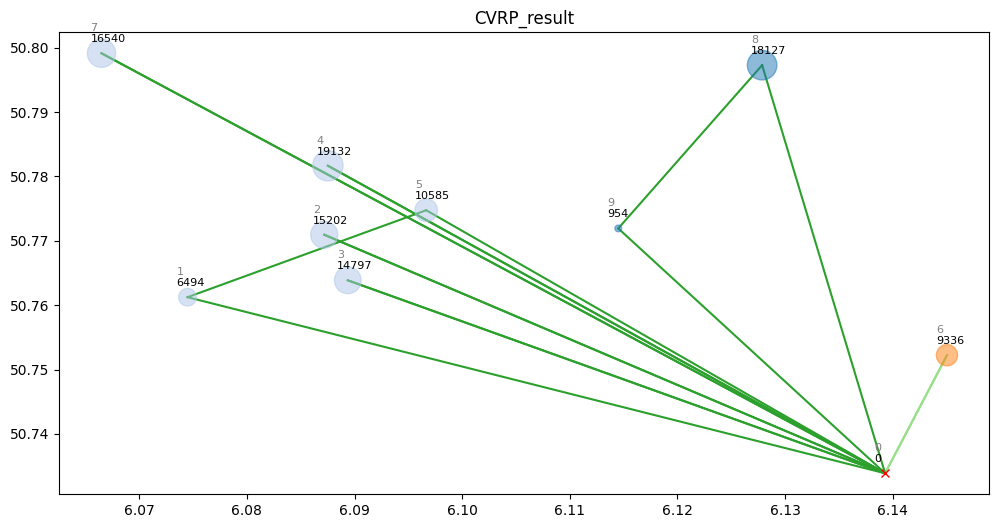

In [33]:
active_routes = [[i,j,k] for i,j in A for k in T if x[i, j, k].x > 0.99]

plt.figure(figsize=(12,6))
plt.plot(x_depot, y_depot, c='r', marker='x') # depot
plt.scatter(x_cus, y_cus, c=[color_map_hex[x] for x in cluster_kmeans.labels_], marker="o", s = d_list, alpha=0.5)
for idx, row in process_df.iterrows():
    plt.annotate(row['demand_kg'], (row['longitude'], row['latitude']), textcoords='offset points', xytext=(-8,8), family='sans-serif', fontsize=8)
    plt.annotate(idx, (row['longitude'], row['latitude']), textcoords='offset points', xytext=(-8,16), family='sans-serif', fontsize=8, c='grey')
for i,j,k in active_routes:
    plt.plot([x_all[i], x_all[j]], [y_all[i], y_all[j]], c=color_map_hex[truck_type_map[k]], zorder=0)
title_name = f'CVRP_result'
plt.title(title_name)
# plt.savefig(f'{title_name}.png') # Save img
plt.show()